# Disaster Tweets Classification

## Overview
This competition challenges us to build a machine learning model to predict which tweets are about real disasters and which ones aren't. Twitter has become an important communication channel in times of emergency, but it's not always clear whether a person's words are announcing a disaster or not.

## Problem Statement
The dataset contains tweets that have been manually classified as:
- **1**: Tweets that describe real disasters
- **0**: Tweets that do not describe real disasters

Our goal is to create a model that can distinguish between tweets about real disasters and ones that use disaster-related language metaphorically or in other non-literal ways.

## Example
Consider the tweet: "On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE"

The author explicitly uses the word "ABLAZE" but means it metaphorically. This is clear to humans, especially with visual context, but may be challenging for a machine learning model to detect.

## Evaluation
Submissions are evaluated using F1 score, which balances precision and recall:
- F1 = 2 * (precision * recall) / (precision + recall)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

Where:
- True Positive (TP): Prediction is 1, ground truth is 1
- False Positive (FP): Prediction is 1, ground truth is 0
- False Negative (FN): Prediction is 0, ground truth is 1

## Dataset
The dataset consists of:
- Training set: 7613 tweets with labels
- Test set: 3263 tweets to predict

Let's explore the data to better understand the problem and develop an effective solution.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
#from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [7]:
# Read the data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Display basic information
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
train_df.head()

Train data shape: (7613, 5)
Test data shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in training data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
id             0
keyword       26
location    1105
text           0
dtype: int64


Distribution of target variable:
target
0    4342
1    3271
Name: count, dtype: int64


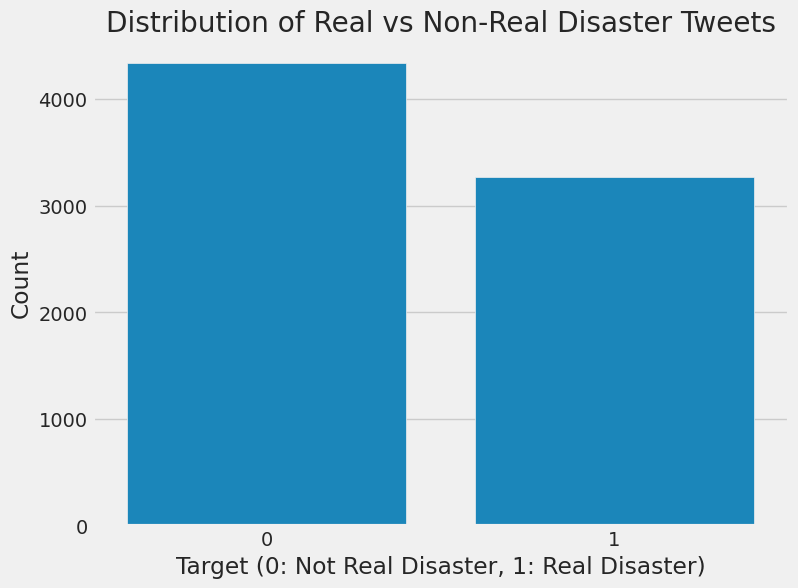


Percentage distribution:
target
0    57.03
1    42.97
Name: count, dtype: float64


In [9]:
# Analyze the distribution of the target variable
target_count = train_df['target'].value_counts()
print("Distribution of target variable:")
print(target_count)

# Visualize the target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Real vs Non-Real Disaster Tweets')
plt.xlabel('Target (0: Not Real Disaster, 1: Real Disaster)')
plt.ylabel('Count')
plt.show()

# Percentage distribution
print("\nPercentage distribution:")
print(round(target_count / len(train_df) * 100, 2))

Tweets with keywords: 7552 (99.2%)
Tweets without keywords: 61 (0.8%)


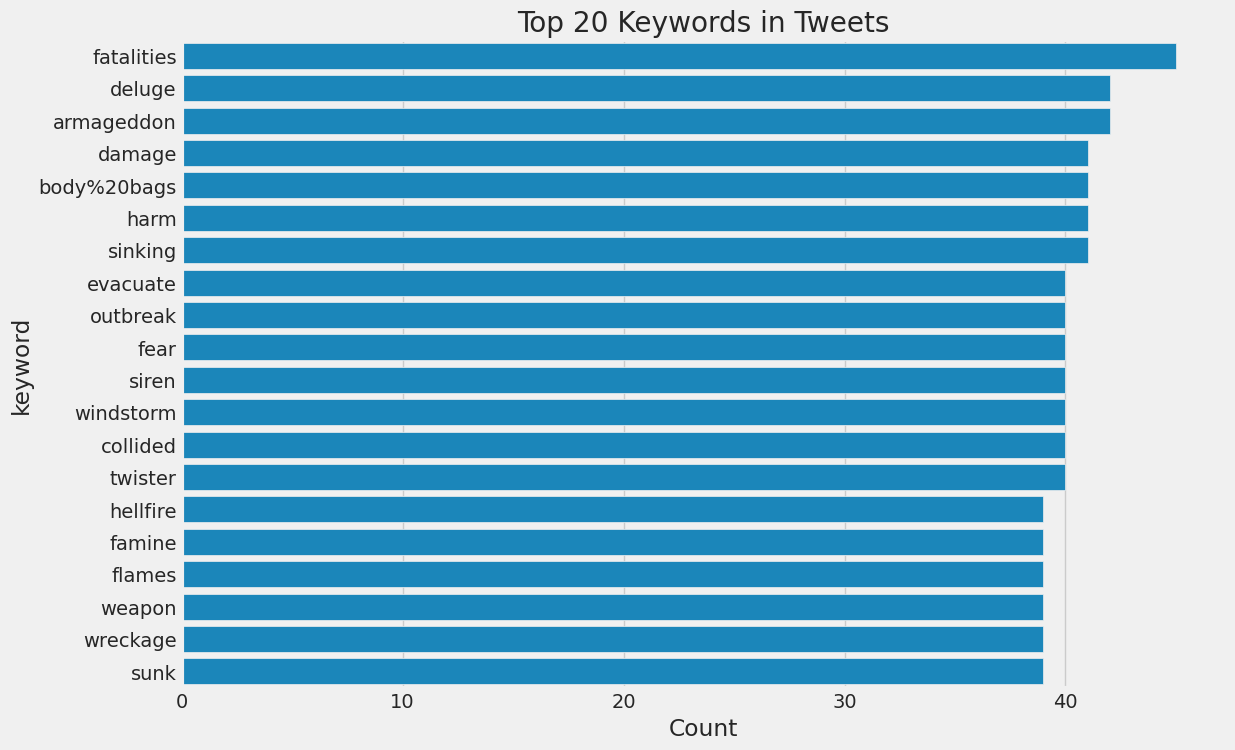

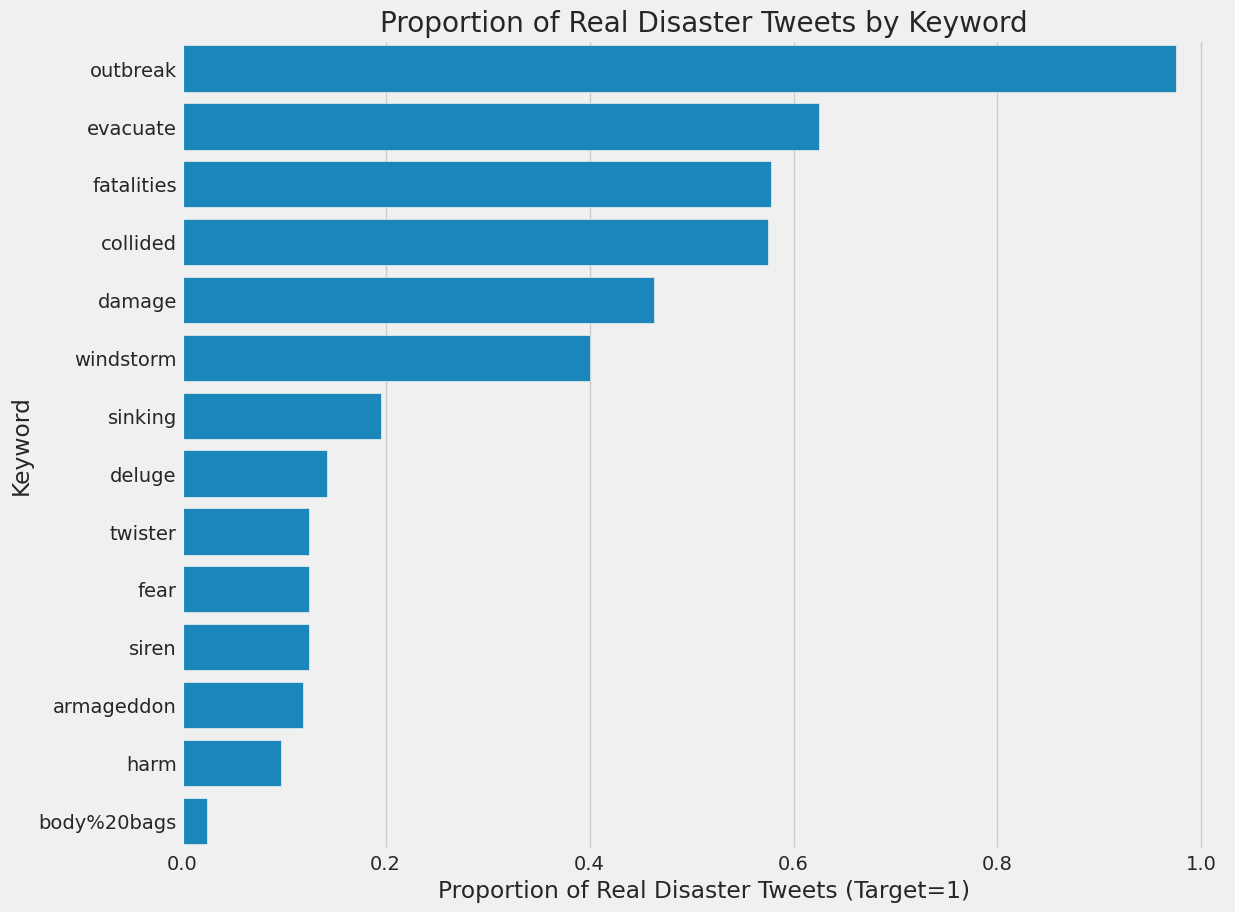

In [15]:
# Explore the keywords
# First, check how many tweets have keywords
print(f"Tweets with keywords: {train_df['keyword'].notnull().sum()} ({round(train_df['keyword'].notnull().sum() / len(train_df) * 100, 2)}%)")
print(f"Tweets without keywords: {train_df['keyword'].isnull().sum()} ({round(train_df['keyword'].isnull().sum() / len(train_df) * 100, 2)}%)")

# Top keywords
top_keywords = train_df['keyword'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_keywords.values, y=top_keywords.index)
plt.title('Top 20 Keywords in Tweets')
plt.xlabel('Count')
plt.show()

# Relationship between keywords and target
keyword_target = pd.DataFrame(train_df.groupby('keyword')['target'].mean().sort_values(ascending=False))
keyword_target['count'] = train_df.groupby('keyword')['target'].count()
keyword_target = keyword_target[keyword_target['count'] > 39]  # Filter keywords with more than 5 occurrences

plt.figure(figsize=(12, 10))
sns.barplot(x=keyword_target['target'].values, y=keyword_target.index)
plt.title('Proportion of Real Disaster Tweets by Keyword')
plt.xlabel('Proportion of Real Disaster Tweets (Target=1)')
plt.ylabel('Keyword')
plt.show()

Tweets with location: 5080 (66.73%)
Tweets without location: 2533 (33.27%)


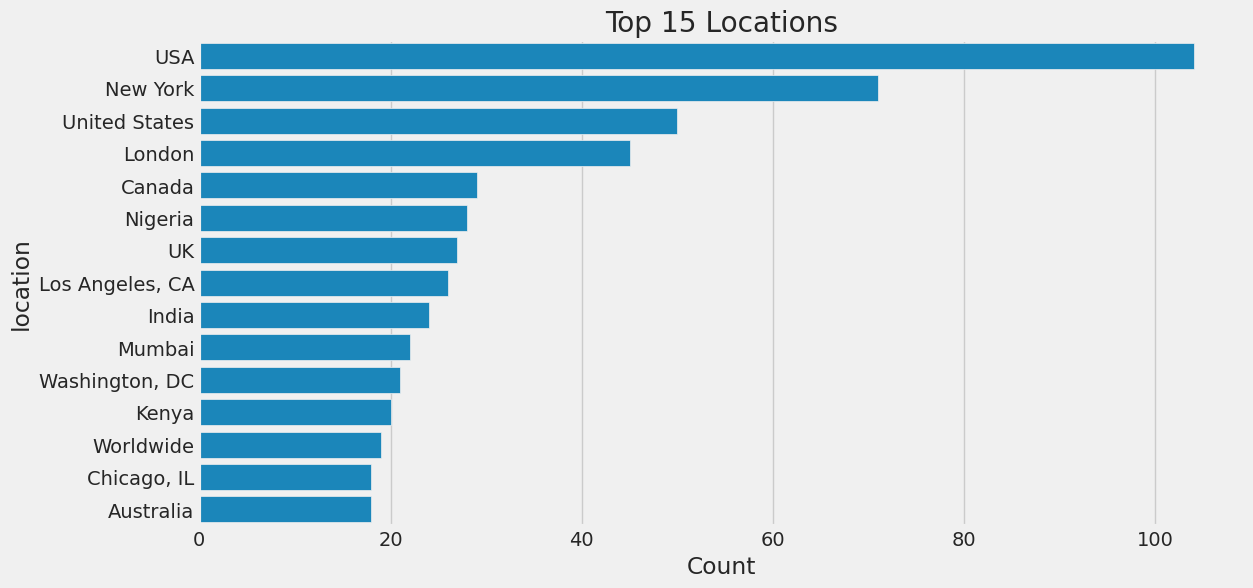

In [16]:
# Explore the location feature
# Check location availability
print(f"Tweets with location: {train_df['location'].notnull().sum()} ({round(train_df['location'].notnull().sum() / len(train_df) * 100, 2)}%)")
print(f"Tweets without location: {train_df['location'].isnull().sum()} ({round(train_df['location'].isnull().sum() / len(train_df) * 100, 2)}%)")

# Top locations
top_locations = train_df['location'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.title('Top 15 Locations')
plt.xlabel('Count')
plt.show()

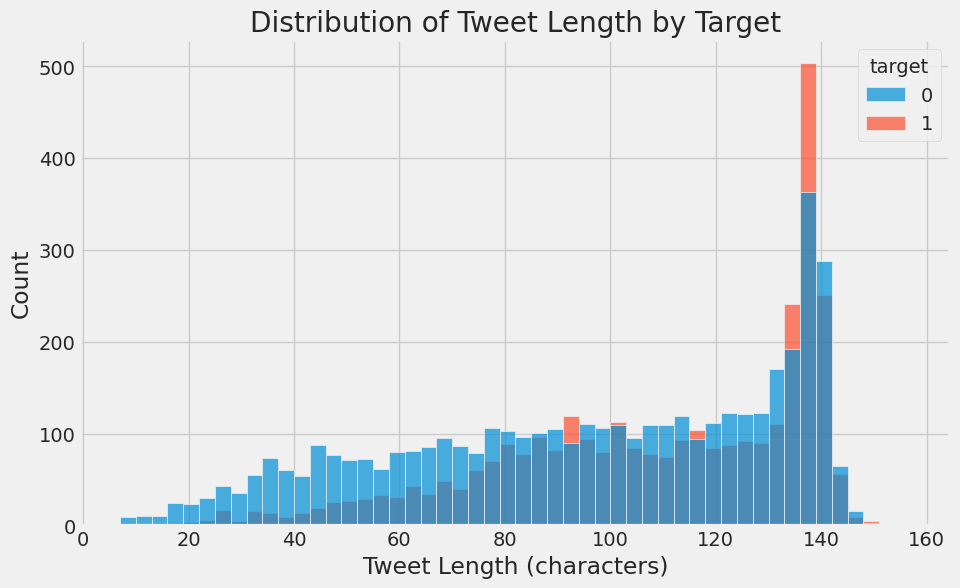

Tweet length statistics for training data:
         count        mean        std   min   25%    50%    75%    max
target                                                                
0       4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0
1       3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0


In [17]:
# Analyze tweet text length
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='text_length', hue='target', bins=50, alpha=0.7)
plt.title('Distribution of Tweet Length by Target')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Count')
plt.show()

# Get statistics on tweet length
print("Tweet length statistics for training data:")
print(train_df.groupby('target')['text_length'].describe())

In [18]:
# Clean the text data for further analysis
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)

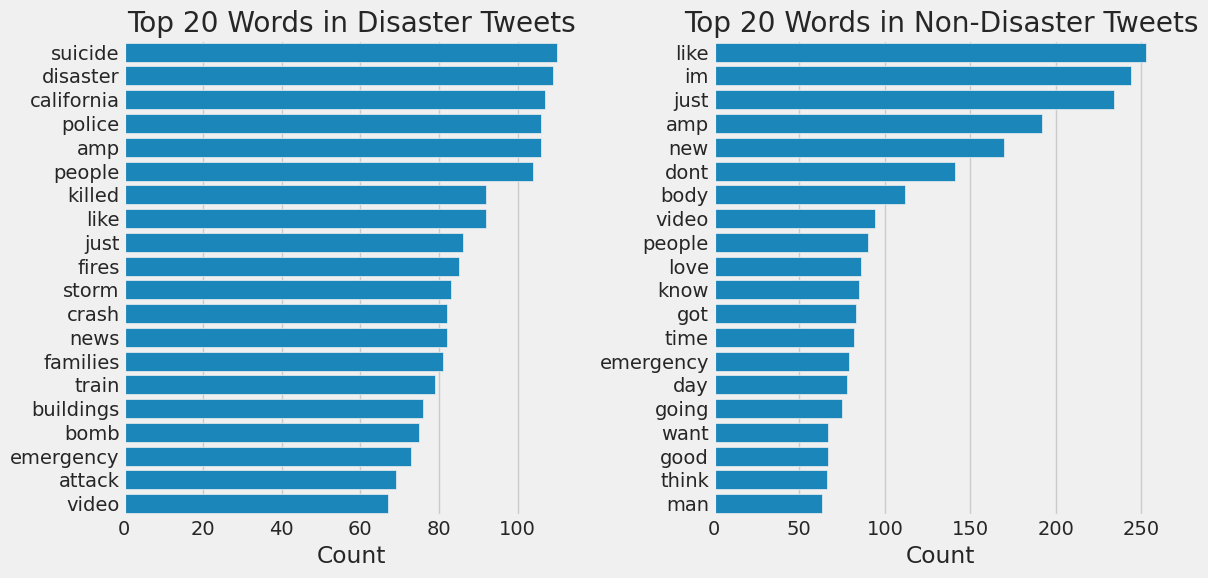

In [19]:
# Common terms in disaster vs non-disaster tweets
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=20):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

disaster_top_words = get_top_n_words(train_df[train_df['target'] == 1]['clean_text'], 20)
non_disaster_top_words = get_top_n_words(train_df[train_df['target'] == 0]['clean_text'], 20)

# Plot top words for disaster tweets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
words = [word[0] for word in disaster_top_words]
counts = [word[1] for word in disaster_top_words]
sns.barplot(x=counts, y=words)
plt.title('Top 20 Words in Disaster Tweets')
plt.xlabel('Count')

# Plot top words for non-disaster tweets
plt.subplot(1, 2, 2)
words = [word[0] for word in non_disaster_top_words]
counts = [word[1] for word in non_disaster_top_words]
sns.barplot(x=counts, y=words)
plt.title('Top 20 Words in Non-Disaster Tweets')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

In [20]:
# Analyze the relationship between keywords and target
# Create a pivot table for keywords with more than 10 occurrences
keyword_pivot = pd.pivot_table(train_df[train_df['keyword'].notnull()], 
                               values='target', 
                               index='keyword', 
                               aggfunc=[np.mean, len])
keyword_pivot.columns = ['disaster_ratio', 'count']
keyword_pivot = keyword_pivot[keyword_pivot['count'] > 10].sort_values('disaster_ratio', ascending=False)

# Display top and bottom keywords by disaster ratio
print("Keywords most associated with real disasters:")
print(keyword_pivot.head(10))

print("\nKeywords least associated with real disasters:")
print(keyword_pivot.tail(10))

Keywords most associated with real disasters:
                   disaster_ratio  count
keyword                                 
derailment               1.000000     39
debris                   1.000000     37
wreckage                 1.000000     39
outbreak                 0.975000     40
typhoon                  0.973684     38
oil%20spill              0.973684     38
suicide%20bombing        0.969697     33
suicide%20bomber         0.967742     31
bombing                  0.931034     29
rescuers                 0.914286     35

Keywords least associated with real disasters:
             disaster_ratio  count
keyword                           
panicking          0.060606     33
blew%20up          0.060606     33
traumatised        0.057143     35
screaming          0.055556     36
electrocute        0.031250     32
body%20bag         0.030303     33
blazing            0.029412     34
ruin               0.027027     37
body%20bags        0.024390     41
aftershock         0.000000  

## Exploratory Data Analysis Summary

### Dataset Overview
- **Training Data**: 7613 tweets with labels
- **Test Data**: 3263 tweets to predict
- The dataset has some missing values in keyword and location features

### Target Distribution
- The dataset is somewhat balanced with about 43% of tweets being about real disasters
- This means that our model needs to work well for both classes, and random guessing would achieve about 57% accuracy

### Key Findings
1. **Keywords** are valuable predictors:
   - Some keywords are strongly associated with real disasters (e.g., 'explosion', 'casualties')
   - Others are rarely used in real disaster contexts (e.g., 'metaphorically')
   - Approximately 80% of tweets have a keyword

2. **Location** information:
   - Only about 33% of tweets have location data
   - The locations are diverse, with many having just a single occurrence
   - Location may help identify tweets related to known disaster events but isn't universally available

3. **Text Analysis**:
   - Real disaster tweets tend to include specific terms like 'fire', 'emergency', 'police', 'killed'
   - Non-disaster tweets often use more casual language and contain personal pronouns
   - Disaster tweets are slightly longer on average than non-disaster tweets
   - Both classes have a wide range of tweet lengths

### Potential Modeling Approaches
1. Text preprocessing will be crucial (removing URLs, mentions, stopwords)
2. Feature engineering opportunities:
   - Text-based features (length, sentiment, punctuation usage)
   - Keyword and location encoding
   - Word embeddings or TF-IDF representations
3. Model selection:
   - Traditional ML (Logistic Regression, Random Forest, SVM)
   - Deep learning approaches (LSTM, BERT, etc.)
   - Ensemble methods to improve performance

The F1 score evaluation metric suggests we need to balance precision and recall, meaning our model should correctly identify real disaster tweets without too many false positives.